<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/XGBoostand_LSTM_on_Largest_S%26P50_Stocksipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, log_loss
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files
import io
import joblib

In [10]:
import warnings
warnings.filterwarnings('ignore')


In [11]:
# List of the 50 largest companies in the S&P 500 for the tickers
symbols = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'BRK-B', 'GOOG','LLY','AVGO','JPM','TSLA','UNH','XOM','V','PG','JNJ','MA','COST','HD','ABBV','WMT','NFLX','MRK','KO','BAC','ADBE','CVX','CRM','AMD','PEP','TMO','LIN','ORCL','ACN','MCD','CSCO','WFC','ABT','QCOM','TXN','PM','GE','IBM','AMGN','DHR','INTU','VZ','NOW','ISRG']


In [12]:
# Create a dataframe over the last decade on a daily basis and get the Open, High, Low, Close , Adj Close and Volume for each stock

df = yf.download(tickers = symbols, period = "10y", interval = "1d")


[**********************66%*******                ]  33 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************68%********               ]  34 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************68%********               ]  34 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************74%***********            ]  37 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************76%***********            ]  38 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10


In [13]:
df.head()

Price                      Adj Close                                   \
Ticker                          AAPL       ABBV        ABT        ACN   
Date                                                                    
2014-09-22 00:00:00+00:00  22.432976  38.836376  35.847614  66.527916   
2014-09-23 00:00:00+00:00  22.783703  38.075661  35.104252  66.847038   
2014-09-24 00:00:00+00:00  22.586143  39.061283  35.211620  67.350906   
2014-09-25 00:00:00+00:00  21.724871  38.366707  34.691254  66.326370   
2014-09-26 00:00:00+00:00  22.364166  39.153893  34.699516  66.586708   

Price                                                                        \
Ticker                          ADBE   AMD        AMGN       AMZN      AVGO   
Date                                                                          
2014-09-22 00:00:00+00:00  67.199997  3.76  107.354591  16.225000  6.638526   
2014-09-23 00:00:00+00:00  67.790001  3.69  106.221985  16.181499  6.667463   
2014-09-24 00:00:00+00:00  69.029999  3.70  107.399887  16.410500  6.778639   
2014-09-25 00:00:00+00:00  67.709999  3.63  105.595306  16.096500  6.583701   
2014-09-26 00:00:00+00:00  68.360001  3.60  106.508942  16.160500  6.662895   

Price                                 ...    Volume                      \
Ticker                           BAC  ...      QCOM      TMO       TSLA   
Date                                  ...                                 
2014-09-22 00:00:00+00:00  13.862660  ...  10447100   975000  123211500   
2014-09-23 00:00:00+00:00  13.878933  ...   8788800  1203600   84880500   
2014-09-24 00:00:00+00:00  13.984756  ...   6097800  2027500   56242500   
2014-09-25 00:00:00+00:00  13.716132  ...   7452200  1837500   72513000   
2014-09-26 00:00:00+00:00  13.862660  ...   6816400  1004600   56931000   

Price                                                                      \
Ticker                         TXN      UNH         V        VZ       WFC   
Date                                                                        
2014-09-22 00:00:00+00:00  5756500  2335400   9074000  14728500  13445700   
2014-09-23 00:00:00+00:00  5646900  2640200   7959600  10614500  20596500   
2014-09-24 00:00:00+00:00  5125600  2661500   8336000  11488600  18245200   
2014-09-25 00:00:00+00:00  5297300  3657100  11729600  13665800  16684900   
2014-09-26 00:00:00+00:00  3601700  2260500   7178800   9036200  10753400   

Price                                          
Ticker                          WMT       XOM  
Date                                           
2014-09-22 00:00:00+00:00  13352100   8816900  
2014-09-23 00:00:00+00:00  20124000  10300700  
2014-09-24 00:00:00+00:00  25303800  12200000  
2014-09-25 00:00:00+00:00  14890500  12854200  
2014-09-26 00:00:00+00:00  11258700  11256800  

[5 rows x 300 columns]

In [14]:
# If a column has more than 20% NaNs then drop it, otherwise replace the NaN with the mean of the column

threshold = len(df) * 0.2
for column in df.columns:
  if df[column].isna().sum() > threshold:
    df = df.drop(column, axis=1)
  else:
    df[column] = df[column].fillna(df[column].mean())


In [15]:
# Check for NaNs
df.isna().sum().sum()

0

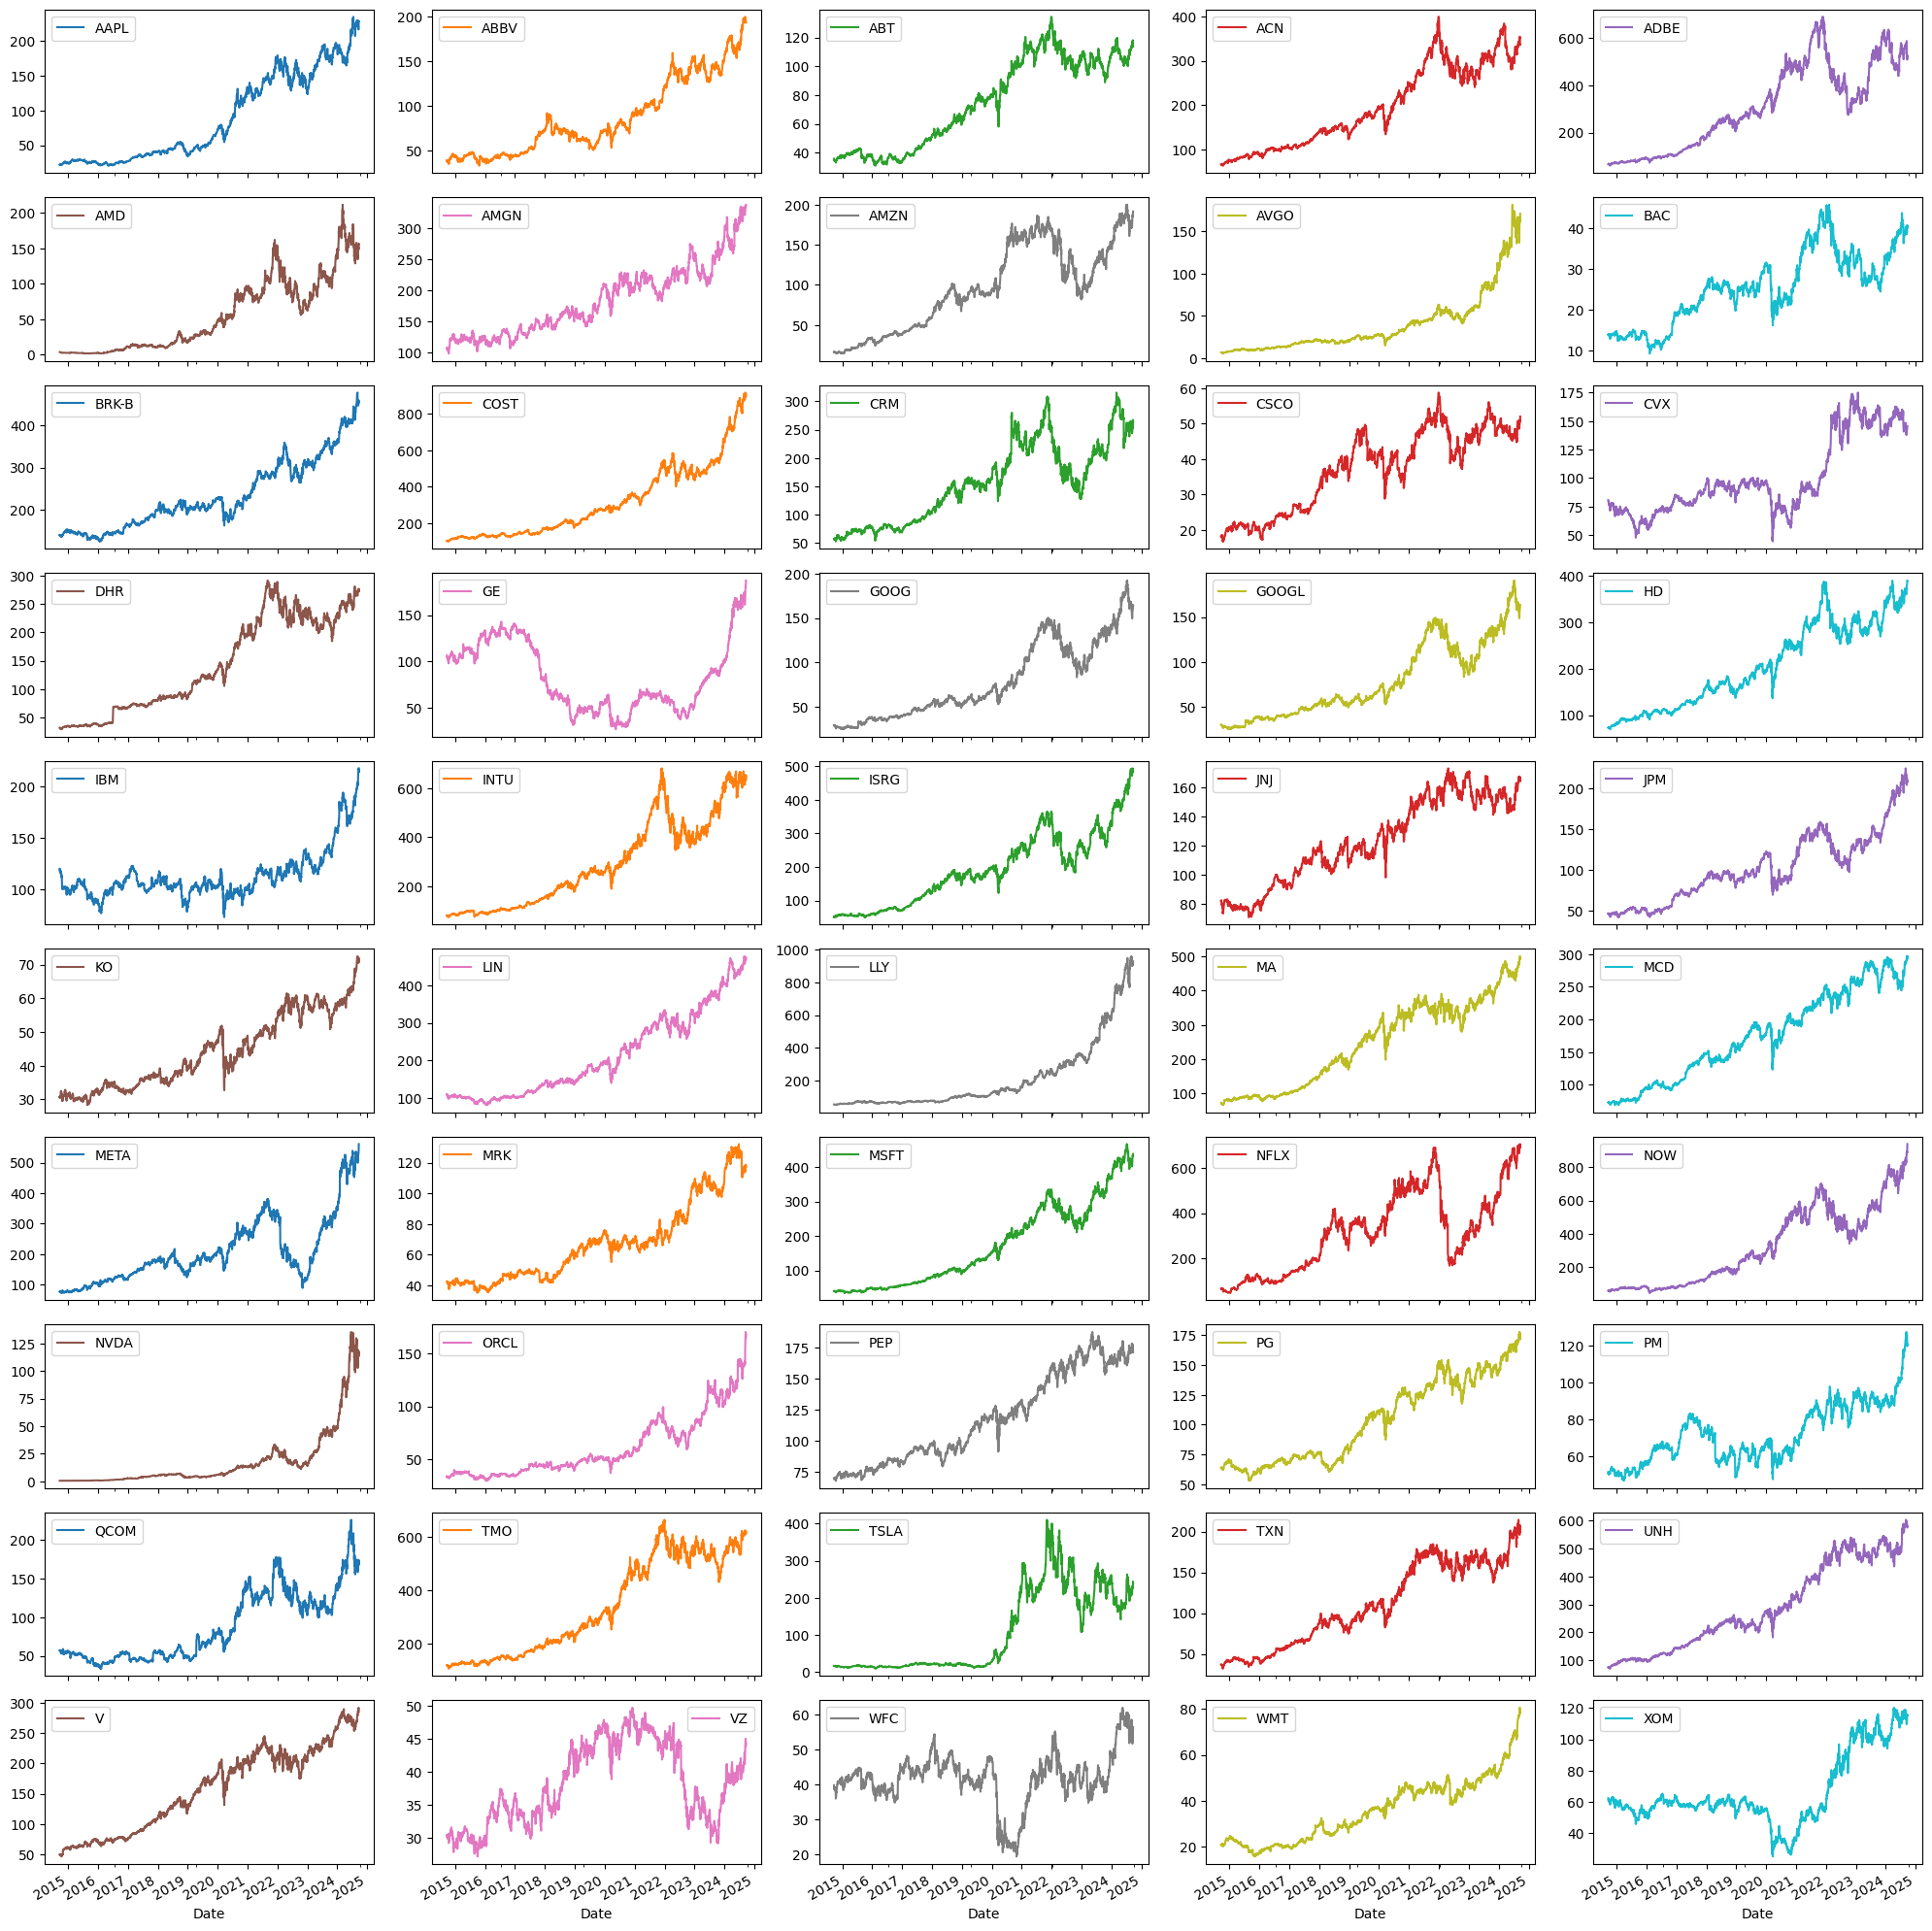

In [16]:
# Plot the Adj Close price for each stock on a separate subplot
df['Adj Close'].plot(subplots=True, layout=(10,5), figsize=(20,20))
plt.tight_layout()
plt.show()


In [17]:
# Create a dataframe for each stock using the downloaded data, for each stock recorf the open, high, low, close, adj close and volume

stock_dfs = {}
for symbol in symbols:
  stock_dfs[symbol] = df.loc[:, (['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], symbol)]

# Access the dataframe for a specific stock
# Example: AAPL
apple_df = stock_dfs['AAPL']
print(apple_df.head())


Price                           Open       High        Low      Close  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2014-09-22 00:00:00+00:00  25.450001  25.535000  25.145000  25.264999   
2014-09-23 00:00:00+00:00  25.150000  25.735001  25.135000  25.660000   
2014-09-24 00:00:00+00:00  25.540001  25.712500  25.299999  25.437500   
2014-09-25 00:00:00+00:00  25.127501  25.177500  24.430000  24.467501   
2014-09-26 00:00:00+00:00  24.632500  25.187500  24.600000  25.187500   

Price                      Adj Close     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2014-09-22 00:00:00+00:00  22.432976  211153600  
2014-09-23 00:00:00+00:00  22.783703  253608800  
2014-09-24 00:00:00+00:00  22.586143  240687200  
2014-09-25 00:00:00+00:00  21.724871  400368000  
2014-09-26 00:00:00+00:00  22.364166  249482000  


In [18]:
# For each dataframe in the dictionary create add the following features through feature engineerg: daily variation = (high-low)/open, daily return=close percentage change, 7 day SMA, 7 day STD, SMA+2*STD, SMA-2*STD, High-Close = (High-Close)/Open, Low - Open = (Low-Open)/Open, Cumulative Return, 14 Day EMA, Close % change, Close Change

for symbol in stock_dfs:
  # Daily Variation
  stock_dfs[symbol]['Daily Variation'] = (stock_dfs[symbol]['High'] - stock_dfs[symbol]['Low']) / stock_dfs[symbol]['Open']
  # Daily Return
  stock_dfs[symbol]['Daily Return'] = stock_dfs[symbol]['Close'].pct_change()
  # 7 Day SMA
  stock_dfs[symbol]['7 Day SMA'] = stock_dfs[symbol]['Close'].rolling(window=7).mean()
  # 7 Day STD
  stock_dfs[symbol]['7 Day STD'] = stock_dfs[symbol]['Close'].rolling(window=7).std()
  # SMA + 2*STD
  stock_dfs[symbol]['SMA+2*STD'] = stock_dfs[symbol]['7 Day SMA'] + 2 * stock_dfs[symbol]['7 Day STD']
  # SMA - 2*STD
  stock_dfs[symbol]['SMA-2*STD'] = stock_dfs[symbol]['7 Day SMA'] - 2 * stock_dfs[symbol]['7 Day STD']
  # High - Close
  stock_dfs[symbol]['High-Close'] = (stock_dfs[symbol]['High'] - stock_dfs[symbol]['Close']) / stock_dfs[symbol]['Open']
  # Low - Open
  stock_dfs[symbol]['Low-Open'] = (stock_dfs[symbol]['Low'] - stock_dfs[symbol]['Open']) / stock_dfs[symbol]['Open']
  # Cumulative Return
  stock_dfs[symbol]['Cumulative Return'] = (1 + stock_dfs[symbol]['Daily Return']).cumprod()
  # 14 Day EMA
  stock_dfs[symbol]['14 Day EMA'] = stock_dfs[symbol]['Close'].ewm(span=14).mean()
  # Close % Change
  stock_dfs[symbol]['Close % Change'] = stock_dfs[symbol]['Close'].pct_change()
  # Close Change
  stock_dfs[symbol]['Close Change'] = stock_dfs[symbol]['Close'] - stock_dfs[symbol]['Close'].shift(1)


In [19]:
print(stock_dfs['AAPL'].head())

Price                           Open       High        Low      Close  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2014-09-22 00:00:00+00:00  25.450001  25.535000  25.145000  25.264999   
2014-09-23 00:00:00+00:00  25.150000  25.735001  25.135000  25.660000   
2014-09-24 00:00:00+00:00  25.540001  25.712500  25.299999  25.437500   
2014-09-25 00:00:00+00:00  25.127501  25.177500  24.430000  24.467501   
2014-09-26 00:00:00+00:00  24.632500  25.187500  24.600000  25.187500   

Price                      Adj Close     Volume Daily Variation Daily Return  \
Ticker                          AAPL       AAPL                                
Date                                                                           
2014-09-22 00:00:00+00:00  22.432976  211153600        0.015324          NaN   
2014-09-23 00:00:00+00:00  22.783703  253608800        0.023857     0.015634   
2014-09-24 00:0

In [20]:
# Eliminate rows with NaN values then reset the index with drop=True

for symbol in stock_dfs:
  stock_dfs[symbol] = stock_dfs[symbol].dropna().reset_index(drop=True)


In [21]:
# For each dataframe calculate the mutual information between the Adj Close and the other non index columns, drop columns with a mutual information score of 0

for symbol in stock_dfs:
  X = stock_dfs[symbol].copy()
  y = X.pop('Adj Close')

  # Calculate mutual information
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)

  # Drop columns with zero mutual information
  columns_to_drop = mi_scores[mi_scores == 0].index
  stock_dfs[symbol] = stock_dfs[symbol].drop(columns_to_drop, axis=1)


In [22]:
#  Take the Adj price for each stock. If it rises on the next day then make a "Buy" signal, if it goes down the next day then put a "Sell" signal. Save the list of signals in a dictionary called actions. Ensure the price changes are all integers

actions = {}
for symbol in stock_dfs:
  df = stock_dfs[symbol]
  close_prices = df['Adj Close'].values
  signals = []
  for i in range(len(close_prices) - 1):
    change = int(close_prices[i + 1] - close_prices[i])  # Calculate price change as integer
    if change > 0:
      signals.append('Buy')
    elif change < 0:
      signals.append('Sell')
    else:
      signals.append('Hold')
  actions[symbol] = signals


In [23]:
# Apply label encoding to actions
label_encoder = LabelEncoder()
encoded_actions = {}
for symbol in actions:
  encoded_actions[symbol] = label_encoder.fit_transform(actions[symbol])


In [24]:
# Create a new dictionary called features which takes the stock_dfs and drops the Adj Close column for each stock

features = {}
for symbol in stock_dfs:
  features[symbol] = stock_dfs[symbol].drop('Adj Close', axis=1)


In [25]:
# Apply the standard scaler to the features
scaled_features = {}
for symbol in features:
  scaler = StandardScaler()
  scaled_features[symbol] = scaler.fit_transform(features[symbol])



In [26]:
# Drop the first entry for each of the scaled features

for symbol in scaled_features:
  scaled_features[symbol] = scaled_features[symbol][1:]


In [27]:
# Take the last 10 days from the scaled_features and the first 10 days from the encoded actions away to prevent lookahead bias

final_scaled_features = {}
final_encoded_actions = {}

for symbol in scaled_features:
  final_scaled_features[symbol] = scaled_features[symbol][:-10]
  final_encoded_actions[symbol] = encoded_actions[symbol][10:]


In [28]:
# Do an 80-20 train test split on the final scaled features and final encoded actions for each ticker

train_features = {}
test_features = {}
train_actions = {}
test_actions = {}

for symbol in final_scaled_features:
  X_train, X_test, y_train, y_test = train_test_split(
      final_scaled_features[symbol], final_encoded_actions[symbol], test_size=0.2, random_state=42
  )
  train_features[symbol] = X_train
  test_features[symbol] = X_test
  train_actions[symbol] = y_train
  test_actions[symbol] = y_test


In [29]:
# Convert train and test features to numpy arrays
for symbol in train_features:
  train_features[symbol] = np.array(train_features[symbol])
  test_features[symbol] = np.array(test_features[symbol])


In [30]:
# Check the dimensions of the training and testing data

for symbol in train_features:
  print(f"Training data for {symbol}: {train_features[symbol].shape}")
  print(f"Testing data for {symbol}: {test_features[symbol].shape}")
  print(f"Training actions for {symbol}: {len(train_actions[symbol])}")
  print(f"Testing actions for {symbol}: {len(test_actions[symbol])}")



Training data for AAPL: (2000, 17)
Testing data for AAPL: (500, 17)
Training actions for AAPL: 2000
Testing actions for AAPL: 500
Training data for MSFT: (2000, 17)
Testing data for MSFT: (500, 17)
Training actions for MSFT: 2000
Testing actions for MSFT: 500
Training data for NVDA: (2000, 17)
Testing data for NVDA: (500, 17)
Training actions for NVDA: 2000
Testing actions for NVDA: 500
Training data for AMZN: (2000, 17)
Testing data for AMZN: (500, 17)
Training actions for AMZN: 2000
Testing actions for AMZN: 500
Training data for META: (2000, 17)
Testing data for META: (500, 17)
Training actions for META: 2000
Testing actions for META: 500
Training data for GOOGL: (2000, 17)
Testing data for GOOGL: (500, 17)
Training actions for GOOGL: 2000
Testing actions for GOOGL: 500
Training data for BRK-B: (2000, 17)
Testing data for BRK-B: (500, 17)
Training actions for BRK-B: 2000
Testing actions for BRK-B: 500
Training data for GOOG: (2000, 17)
Testing data for GOOG: (500, 17)
Training actio

In [31]:
# Define the Blocking Time Series Split
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
    self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
    return self.n_splits

  def split(self, X, y=None, groups=None):
    n_samples = len(X)
    k_fold_size = n_samples // self.n_splits
    indices = np.arange(n_samples)

    margin = 0
    for i in range(self.n_splits):
      start = i * k_fold_size
      stop = start + k_fold_size
      mid = int(0.5 * (stop - start)) + start
      yield indices[start: mid], indices[mid + margin: stop]

In [32]:
# Initialize a dictionary to store the best models
best_models = {}

# Iterate through each stock and perform GridSearchCV with BlockingTimeSeriesSplit
for symbol in train_features:
  # Define the parameter grid for XGBoost
  param_grid = {
      'n_estimators': [50, 100, 200],
      'max_depth': [3, 5, 7],
      'learning_rate': [0.01, 0.1, 0.2],
  }

  # Initialize XGBoost classifier
  model = xgb.XGBClassifier()

  seed_value = 42
  model.set_params(seed=seed_value)

  # Initialize BlockingTimeSeriesSplit
  btscv = BlockingTimeSeriesSplit(n_splits=5)

  # Perform GridSearchCV
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=btscv, scoring='accuracy')
  grid_search.fit(train_features[symbol], train_actions[symbol])

  # Store the best model
  best_models[symbol] = grid_search.best_estimator_

  # Print the best hyperparameters for the current stock
  print(f"Best hyperparameters for {symbol}: {grid_search.best_params_}")


Best hyperparameters for AAPL: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for MSFT: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}
Best hyperparameters for NVDA: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best hyperparameters for AMZN: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for META: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for GOOGL: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best hyperparameters for BRK-B: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for GOOG: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for LLY: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for AVGO: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for JPM: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7b5ee09ffd00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 626, in input_data
    self.proxy.set_info(
  File "/usr/local/lib/python3.1

Best hyperparameters for CSCO: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best hyperparameters for WFC: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for ABT: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for QCOM: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for TXN: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for PM: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best hyperparameters for GE: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best hyperparameters for IBM: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best hyperparameters for AMGN: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters for DHR: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best hyperparameters for INTU: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best 

In [33]:
# Generate predictions using the test features using the best models
predictions = {}
for symbol in best_models:
  predictions[symbol] = best_models[symbol].predict(test_features[symbol])


In [34]:
# Get the metrics between the predictions and testing data for each ticker and present as a dataframe
metrics_data = []
for symbol in predictions:
  accuracy = accuracy_score(test_actions[symbol], predictions[symbol])
  f1 = f1_score(test_actions[symbol], predictions[symbol], average='weighted')
  balanced_accuracy = balanced_accuracy_score(test_actions[symbol], predictions[symbol])

  metrics_data.append([symbol, accuracy, f1, balanced_accuracy])

metrics_df = pd.DataFrame(metrics_data, columns=['Ticker', 'Accuracy', 'F1 Score', 'Balanced Accuracy'])

print(metrics_df)


   Ticker  Accuracy  F1 Score  Balanced Accuracy
0    AAPL     0.636  0.602684           0.441253
1    MSFT     0.542  0.537532           0.484081
2    NVDA     0.908  0.892115           0.463080
3    AMZN     0.576  0.560266           0.460255
4    META     0.418  0.406963           0.415056
5   GOOGL     0.644  0.620700           0.427749
6   BRK-B     0.442  0.417450           0.411658
7    GOOG     0.640  0.554054           0.357640
8     LLY     0.570  0.550229           0.504972
9    AVGO     0.830  0.792950           0.450018
10    JPM     0.604  0.498713           0.366387
11   TSLA     0.682  0.671253           0.575697
12    UNH     0.468  0.452513           0.453822
13    XOM     0.724  0.623227           0.343108
14      V     0.486  0.468547           0.429563
15     PG     0.726  0.619020           0.335098
16    JNJ     0.664  0.533920           0.340426
17     MA     0.526  0.500550           0.496936
18   COST     0.482  0.443122           0.454322
19     HD     0.512 

In [35]:
feature_importance_data = []
for symbol in best_models:
  model = best_models[symbol]
  feature_importances = model.feature_importances_
  feature_names = features[symbol].columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
  top_6_features = feature_importance_df.head(6)
  for index, row in top_6_features.iterrows():
    feature_importance_data.append([symbol, row['Feature'], row['Importance']])

feature_importance_df = pd.DataFrame(feature_importance_data, columns=['Ticker', 'Feature', 'Importance'])
print(feature_importance_df)


    Ticker         Feature  Importance
0     AAPL   (SMA+2*STD, )    0.646253
1     AAPL  (14 Day EMA, )    0.161439
2     AAPL    (Open, AAPL)    0.034296
3     AAPL   (7 Day STD, )    0.023194
4     AAPL   (SMA-2*STD, )    0.016166
..     ...             ...         ...
295   ISRG  (14 Day EMA, )    0.202122
296   ISRG   (7 Day SMA, )    0.158609
297   ISRG    (High, ISRG)    0.152278
298   ISRG    (Open, ISRG)    0.093230
299   ISRG   (SMA+2*STD, )    0.053425

[300 rows x 3 columns]


In [36]:
# Define an LSTM architecture that we will use. As hyperparameters use the number of hidden layers, dropout and number of nodes in and node in dense layers

def create_lstm_model(num_hidden_layers, dropout_rate, num_nodes_lstm, num_nodes_dense):
  """
  Creates an LSTM model with specified hyperparameters.

  Args:
    num_hidden_layers: The number of LSTM hidden layers.
    dropout_rate: The dropout rate for regularization.
    num_nodes_lstm: The number of nodes in each LSTM layer.
    num_nodes_dense: The number of nodes in the dense layer.

  Returns:
    A compiled Keras LSTM model.
  """

  model = Sequential()
  model.add(LSTM(num_nodes_lstm, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
  model.add(tf.keras.layers.Dropout(dropout_rate))

  for _ in range(num_hidden_layers - 1):
    model.add(LSTM(num_nodes_lstm, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(LSTM(num_nodes_lstm, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(Dense(num_nodes_dense, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


Unable to import KerasClassifier to use as a wrapper so a loop was used instead

In [37]:
# Initialize a dictionary to store the best LSTM models
best_lstm_models = {}

# Iterate through each stock and perform GridSearchCV with BlockingTimeSeriesSplit for LSTM
for symbol in train_features:
  tf.random.set_seed(42)
  # Reshape the data for LSTM input (samples, timesteps, features)
  X_train_lstm = train_features[symbol].reshape(train_features[symbol].shape[0], 1, train_features[symbol].shape[1])
  X_test_lstm = test_features[symbol].reshape(test_features[symbol].shape[0], 1, test_features[symbol].shape[1])

  # Define the parameter grid for LSTM
  param_grid_lstm = {
      'num_hidden_layers': [1, 2],
      'dropout_rate': [0.2, 0.5],
      'num_nodes_lstm': [32, 64],
      'num_nodes_dense': [16, 32]
  }

  # Initialize the best model with None
  best_model = None
  best_accuracy = 0

  # Iterate through the parameter grid
  for num_hidden_layers in param_grid_lstm['num_hidden_layers']:
    for dropout_rate in param_grid_lstm['dropout_rate']:
      for num_nodes_lstm in param_grid_lstm['num_nodes_lstm']:
        for num_nodes_dense in param_grid_lstm['num_nodes_dense']:
          # Create the LSTM model
          model = create_lstm_model(num_hidden_layers, dropout_rate, num_nodes_lstm, num_nodes_dense)

          # Initialize BlockingTimeSeriesSplit
          btscv = BlockingTimeSeriesSplit(n_splits=5)

          # Perform cross-validation
          accuracies = []
          for train_index, val_index in btscv.split(X_train_lstm):
            X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
            y_train_fold, y_val_fold = np.array(train_actions[symbol])[train_index], np.array(train_actions[symbol])[val_index]

            model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0)
            _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            accuracies.append(accuracy)

          # Calculate the average accuracy for this set of parameters
          avg_accuracy = np.mean(accuracies)

          # Update the best model if this one is better
          if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_model = model
            best_params = {
                'num_hidden_layers': num_hidden_layers,
                'dropout_rate': dropout_rate,
                'num_nodes_lstm': num_nodes_lstm,
                'num_nodes_dense': num_nodes_dense
            }

  # Store the best LSTM model
  best_lstm_models[symbol] = best_model

  # Print the best hyperparameters for the current stock
  print(f"Best LSTM hyperparameters for {symbol}: {best_params}")


Best LSTM hyperparameters for AAPL: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 32, 'num_nodes_dense': 32}
Best LSTM hyperparameters for MSFT: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 64, 'num_nodes_dense': 16}
Best LSTM hyperparameters for NVDA: {'num_hidden_layers': 2, 'dropout_rate': 0.2, 'num_nodes_lstm': 64, 'num_nodes_dense': 32}
Best LSTM hyperparameters for AMZN: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 64, 'num_nodes_dense': 16}
Best LSTM hyperparameters for META: {'num_hidden_layers': 1, 'dropout_rate': 0.5, 'num_nodes_lstm': 64, 'num_nodes_dense': 32}
Best LSTM hyperparameters for GOOGL: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 32, 'num_nodes_dense': 16}
Best LSTM hyperparameters for BRK-B: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 64, 'num_nodes_dense': 32}
Best LSTM hyperparameters for GOOG: {'num_hidden_layers': 1, 'dropout_rate': 0.2, 'num_nodes_lstm': 32, 'num_

In [38]:
# Generate predictions using the test features using the best LSTM models
lstm_predictions = {}
for symbol in best_lstm_models:
  X_test_lstm = test_features[symbol].reshape(test_features[symbol].shape[0], 1, test_features[symbol].shape[1])
  lstm_predictions[symbol] = np.argmax(best_lstm_models[symbol].predict(X_test_lstm), axis=1)

# Get the metrics between the LSTM predictions and testing data for each ticker and present as a dataframe
lstm_metrics_data = []
for symbol in lstm_predictions:
  accuracy = accuracy_score(test_actions[symbol], lstm_predictions[symbol])
  f1 = f1_score(test_actions[symbol], lstm_predictions[symbol], average='weighted')
  balanced_accuracy = balanced_accuracy_score(test_actions[symbol], lstm_predictions[symbol])

  lstm_metrics_data.append([symbol, accuracy, f1, balanced_accuracy])

lstm_metrics_df = pd.DataFrame(lstm_metrics_data, columns=['Ticker', 'Accuracy', 'F1 Score', 'Balanced Accuracy'])

print(lstm_metrics_df)


16/16 [==============================] - 0s 2ms/step
   Ticker  Accuracy  F1 Score  Balanced Accuracy
0    AAPL     0.634  0.571187           0.459680
1    MSFT     0.610  0.541805           0.521053
2    NVDA     0.912  0.890013           0.448685
3    AMZN     0.604  0.568574           0.509700
4    META     0.420  0.409868           0.426462
5   GOOGL     0.668  0.543847           0.342442
6   BRK-B     0.460  0.435100           0.447004
7    GOOG     0.658  0.522903           0.333333
8     LLY     0.598  0.518691           0.498412
9    AVGO     0.828  0.770790           0.398772
10    JPM     0.600  0.454116           0.339080
11   TSLA     0.700  0.642911           0.588643
12    UNH     0.480  0.473267           0.472165
13    XOM     0.728  0.613407           0.333333
14      V     0.494  0.420591           0.411972
15     PG     0.730  0.616069           0.333333
16    JNJ     0.660  0.524819           0.333333
17     MA     0.520  0.438568           0.478904
18   COST     0.

In [39]:
lstm_feature_importance_data = []
for symbol in best_lstm_models:
  model = best_lstm_models[symbol]
  # Access the weights of the first LSTM layer
  weights = model.layers[0].get_weights()[0]
  # Calculate the absolute mean of the weights for each feature
  feature_importances = np.mean(np.abs(weights), axis=(0, 1))
  feature_names = features[symbol].columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
  top_6_features = feature_importance_df.head(6)
  for index, row in top_6_features.iterrows():
    lstm_feature_importance_data.append([symbol, row['Feature'], row['Importance']])

lstm_feature_importance_df = pd.DataFrame(lstm_feature_importance_data, columns=['Ticker', 'Feature', 'Importance'])
print(lstm_feature_importance_df)


    Ticker              Feature  Importance
0     AAPL         (Open, AAPL)    0.110244
1     AAPL         (High, AAPL)    0.110244
2     AAPL          (Low, AAPL)    0.110244
3     AAPL        (Close, AAPL)    0.110244
4     AAPL       (Volume, AAPL)    0.110244
..     ...                  ...         ...
295   ISRG         (High, ISRG)    0.079325
296   ISRG          (Low, ISRG)    0.079325
297   ISRG        (Close, ISRG)    0.079325
298   ISRG       (Volume, ISRG)    0.079325
299   ISRG  (Daily Variation, )    0.079325

[300 rows x 3 columns]


In [61]:
def backtest(symbol, test_actions, xgb_predictions, lstm_predictions, initial_investment=100000, trading_costs=0.0025):
  """
  Backtests a trading strategy based on XGBoost and LSTM predictions.

  Args:
    symbol: The stock symbol.
    test_actions: The true actions (Buy, Sell, Hold) from the test data.
    xgb_predictions: The predictions from the XGBoost model.
    lstm_predictions: The predictions from the LSTM model.
    initial_investment: The initial investment amount.

  Returns:
    A dictionary containing the backtest results (returns, cumulative returns, Sharpe Ratio, Max Drawdown, number of trades).
  """

  df = stock_dfs[symbol].copy()
  close_prices = df['Adj Close'].values[10 + len(train_actions[symbol]):]  # Adjust for training and lookahead bias
  cash = initial_investment
  shares = 0
  returns = []
  trades = 0

  for i in range(len(test_actions)):
    xgb_pred = xgb_predictions[i]
    lstm_pred = lstm_predictions[i]

    if xgb_pred == 0 and lstm_pred == 0:  # Both predict Buy
      if cash > close_prices[i]*500:
        shares += 500
        cash -= close_prices[i]*500*(1-trading_costs)
        trades += 1
    elif xgb_pred == 1 and lstm_pred == 1:  # Both predict Sell
      if shares > 500:
        cash += shares * close_prices[i]*(1-trading_costs)
        shares = shares-500
        trades += 1

    portfolio_value = cash + shares * close_prices[i]
    returns.append((portfolio_value - initial_investment) / initial_investment)

  cumulative_returns = np.cumprod(np.array(returns) + 1) - 1

  # Calculate Sharpe Ratio (assuming risk-free rate of 0)
  if len(returns) > 0:
    sharpe_ratio = np.mean(returns) / np.std(returns)
  else:
    sharpe_ratio = 0

  # Calculate Max Drawdown
  max_drawdown = 0
  peak = 0
  for i in range(len(cumulative_returns)):
    if cumulative_returns[i] > peak:
      peak = cumulative_returns[i]
    drawdown = (peak - cumulative_returns[i]) / (1 + peak) if peak > 0 else 0
    if drawdown > max_drawdown:
      max_drawdown = drawdown

  results = {
      'returns': returns,
      'cumulative_returns': cumulative_returns,
      'sharpe_ratio': sharpe_ratio,
      'max_drawdown': max_drawdown,
      'num_trades': trades
  }

  return results


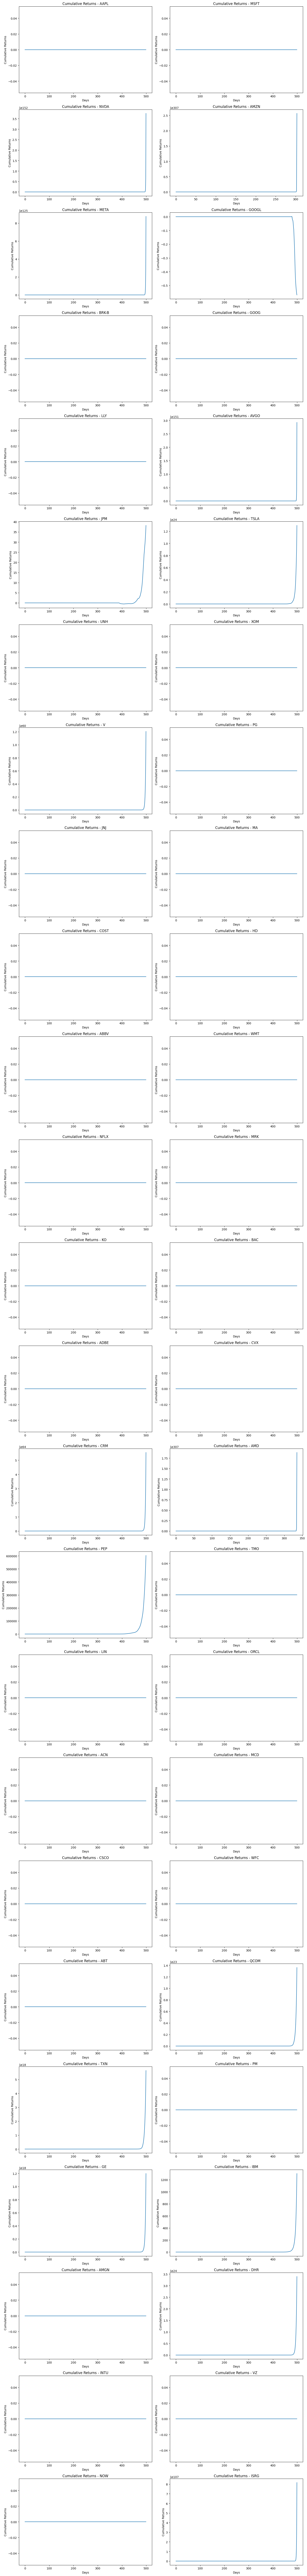

In [62]:
backtest_results = {}
for symbol in predictions:
    backtest_results[symbol] = backtest(symbol, test_actions[symbol], predictions[symbol], lstm_predictions[symbol])

# Create subplots for cumulative returns
num_tickers = len(backtest_results)
rows = (num_tickers + 1) // 2
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, symbol in enumerate(backtest_results):
    row = i // cols
    col = i % cols
    axs[row, col].plot(backtest_results[symbol]['cumulative_returns'])
    axs[row, col].set_title(f'Cumulative Returns - {symbol}')
    axs[row, col].set_xlabel('Days')
    axs[row, col].set_ylabel('Cumulative Returns')

# Remove any empty subplots if the number of tickers is not a multiple of 2
if num_tickers % 2 != 0:
    fig.delaxes(axs[rows - 1, cols - 1])

plt.tight_layout()
plt.show()


In [63]:
backtest_summary_data = []
for symbol in backtest_results:
  results = backtest_results[symbol]
  if not np.isnan(results['sharpe_ratio']):
    backtest_summary_data.append([
        symbol,
        results['sharpe_ratio'],
        results['max_drawdown'],
        results['num_trades']
    ])

backtest_summary_df = pd.DataFrame(backtest_summary_data, columns=['Ticker', 'Sharpe Ratio', 'Max Drawdown', 'Number of Trades'])
print(backtest_summary_df)


   Ticker  Sharpe Ratio  Max Drawdown  Number of Trades
0    NVDA      1.270732      0.000000                27
1    AMZN      1.120226      0.997694               234
2    META      1.329775      0.998654                 1
3   GOOGL     -0.170616      0.569960                 1
4    AVGO      0.911044      0.266860                19
5     JPM      0.276910      0.524157                 1
6    TSLA      0.704509      0.999712                 1
7       V      2.340764      0.009645                 1
8     CRM      1.525896      0.803903                 1
9     AMD      1.256688      0.333855               126
10    PEP      0.784703      0.002612                 1
11   QCOM      0.786974      0.624224                 1
12    TXN      1.157160      0.556208                 1
13     GE      0.660831      0.007258                 1
14    IBM      0.337885      0.044006                 1
15    DHR      0.992953      0.296415                 1
16   ISRG      1.822810      0.093311           